In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import scipy.stats as stats

from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, adjusted_rand_score

from sklearn.metrics import RocCurveDisplay, auc

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


## Importing and processing the dataset

In [3]:
eeg_df = pd.read_csv('EEG-data.csv', index_col=[0])

In [4]:
# Filter the data for patients of class 3 and 4
patient_3_data = eeg_df[eeg_df['y'] == 3].drop(['y'], axis=1)
patient_4_data = eeg_df[eeg_df['y'] == 4].drop(['y'], axis=1)

In [5]:
# Mean and std
patient_4_mean = patient_4_data.mean()
patient_4_std = patient_4_data.std()

patient_3_mean = patient_3_data.mean()
patient_3_std = patient_3_data.std()

In [6]:
# Normalization of class 3 and 4 using Z-score
normalized_pat3 = (patient_3_data - patient_3_mean)/patient_3_std
normalized_pat4 = (patient_4_data - patient_4_mean)/patient_4_std

In [7]:
# Adding target label "y" after normalization and concatenating the data

normalized_pat3['y'] = 3
normalized_pat4['y'] = 4
data = pd.concat([normalized_pat3, normalized_pat4]).reset_index(drop=True)

In [8]:
# Splitting the data into training set (80%) and testing set (20%)
y = data["y"]
X = data.drop(['y'], axis=1)

X_train, X_score, y_train, y_score = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [9]:
# Check stratified sampling
y_train.value_counts()

y
3    80
4    80
Name: count, dtype: int64

In [10]:
# Rename the variables (necessary if outlier detection is not performed)
X, y = X_train, y_train

## Outlier detection

For the detection of the outliers, 2 different criteria were used:

It was considered outlier each sample for which
- more than 50% of the normalized features exceeded 1 normalized standard deviation;
- more than 20% of the normalized features exceeded 2 normalized standard deviation;

In [11]:
# Dividing training set into samples of class 3 and samples of class 4
train = pd.concat([X_train, y_train], axis=1)

train_3 = train[train['y'] == 3].drop(['y'], axis=1).reset_index(drop=True)
train_4 = train[train['y'] == 4].drop(['y'], axis=1).reset_index(drop=True)

In [12]:
# Finding the indeces of the outliers
def outdet(data, percentage):
    outliers = []
    for row_index in range(len(data)):
        mask = data.iloc[row_index].abs().ge(2)     # exceed 2*std
        if len(data.iloc[row_index][mask]) > int(data.shape[1]*percentage):
            outliers.append(row_index)
    return outliers

outlier_index3 = outdet(train_3, 0.20)  # more than 20% of features
outlier_index4 = outdet(train_4, 0.20)

In [13]:
outlier_index3

[4, 18, 40, 69]

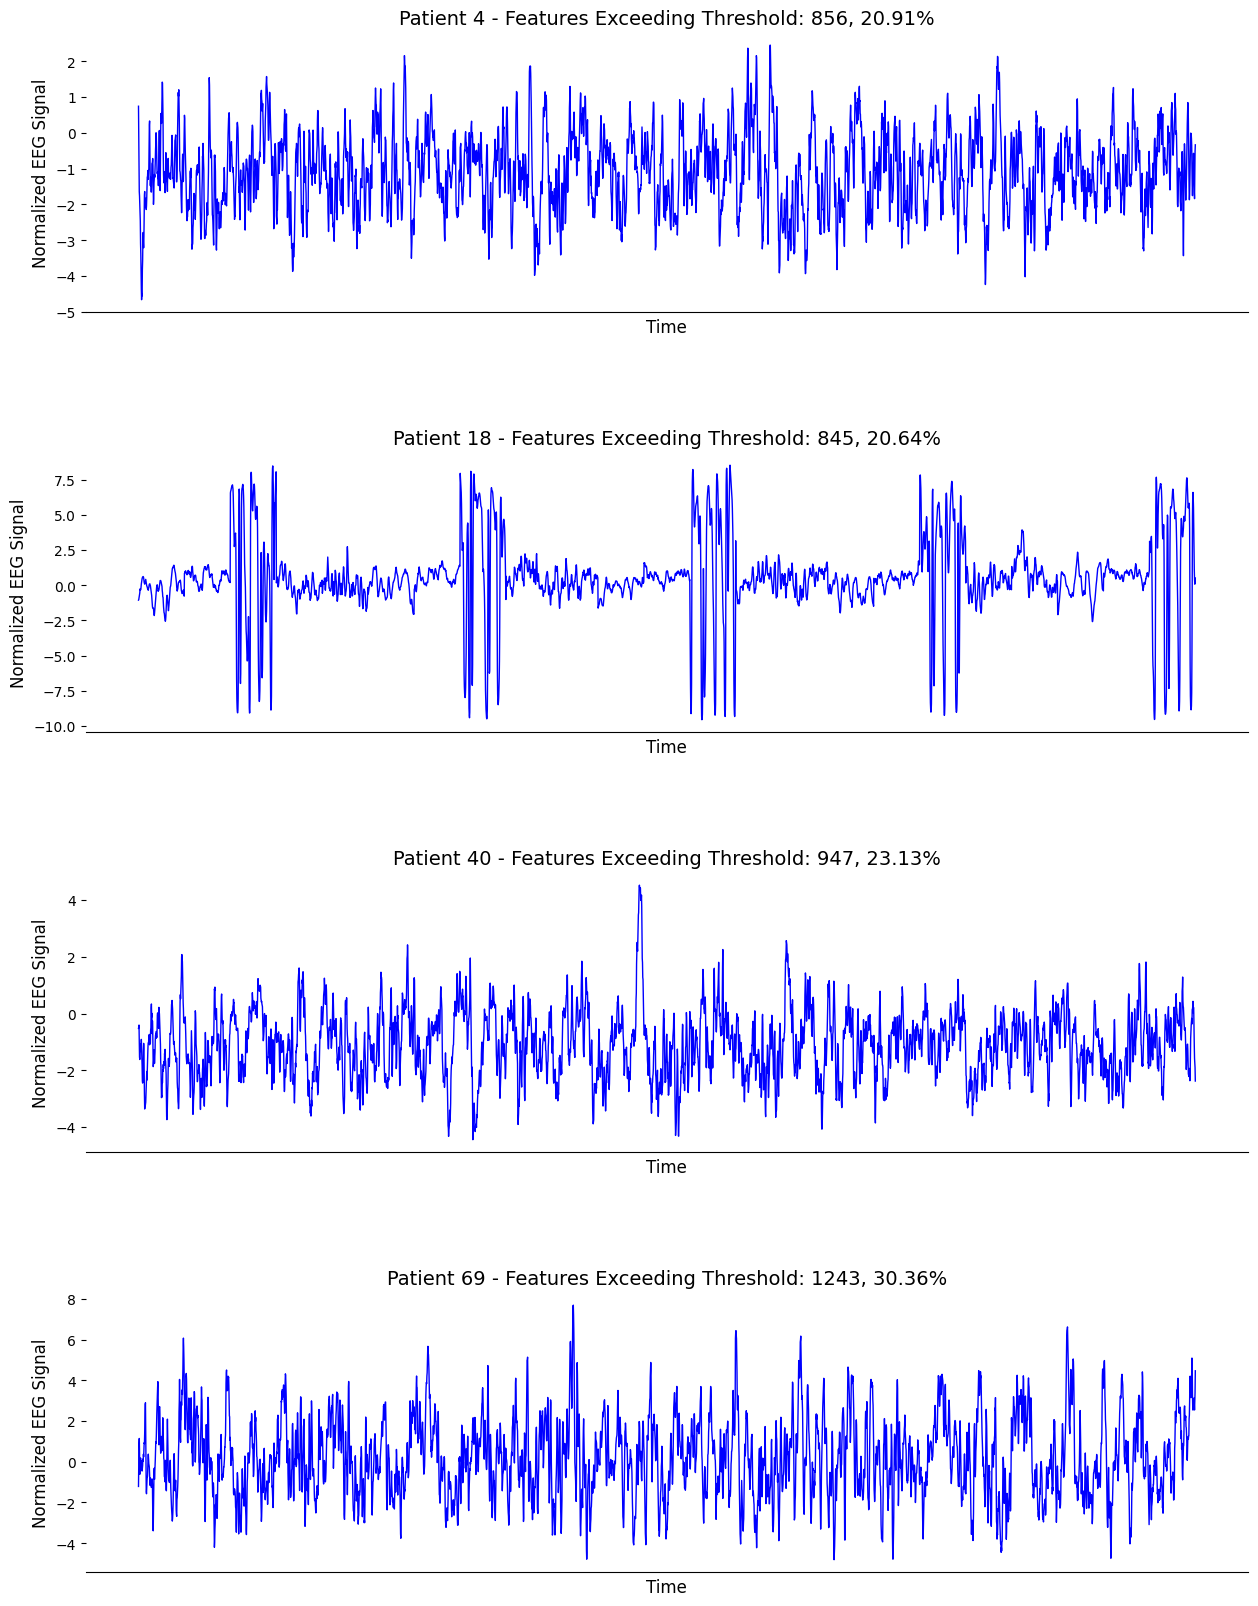

In [14]:
def count_exceeding(data_row, threshold):
    return [sum(abs(data_row) > threshold), round((sum(abs(data_row) > threshold)/train_3.shape[1])*100,2)]

# Plotting the outliers of class 3
fig, ax = plt.subplots(len(outlier_index3), figsize=(15,20))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
for i, j in enumerate(outlier_index3):
    counter = count_exceeding(train_3.iloc[j], 2)
    ax[i].plot(train_3.iloc[j], color='blue', linewidth=1)
    ax[i].set_title(label=f'Patient {j} - Features Exceeding Threshold: {counter[0]}, {counter[1]}%', fontsize=14)
    ax[i].set_xlabel('Time', fontsize=12)
    ax[i].set_ylabel('Normalized EEG Signal', fontsize=12)
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].set_facecolor('white')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_xticks([])  # Hide x-axis ticks
    #ax[i].set_yticks([])  # Hide y-axis ticks
#plt.savefig("outliers.png", dpi=300)
plt.show()

In [16]:
# Reassigning labels after having saved outliers

train_3['y'] = 3
train_4['y'] = 4

In [17]:
# Removing the outliers from the training set

train_3_noOut = train_3.drop(outlier_index3).reset_index(drop=True)
train_4_noOut = train_4.drop(outlier_index4).reset_index(drop=True)

train_noOut = pd.concat([train_3_noOut, train_4_noOut]).reset_index(drop=True)

In [18]:
# Dividing features and labels
y = train_noOut["y"]
X = train_noOut.drop(['y'], axis=1)

## Descriptive analysis

### Plots

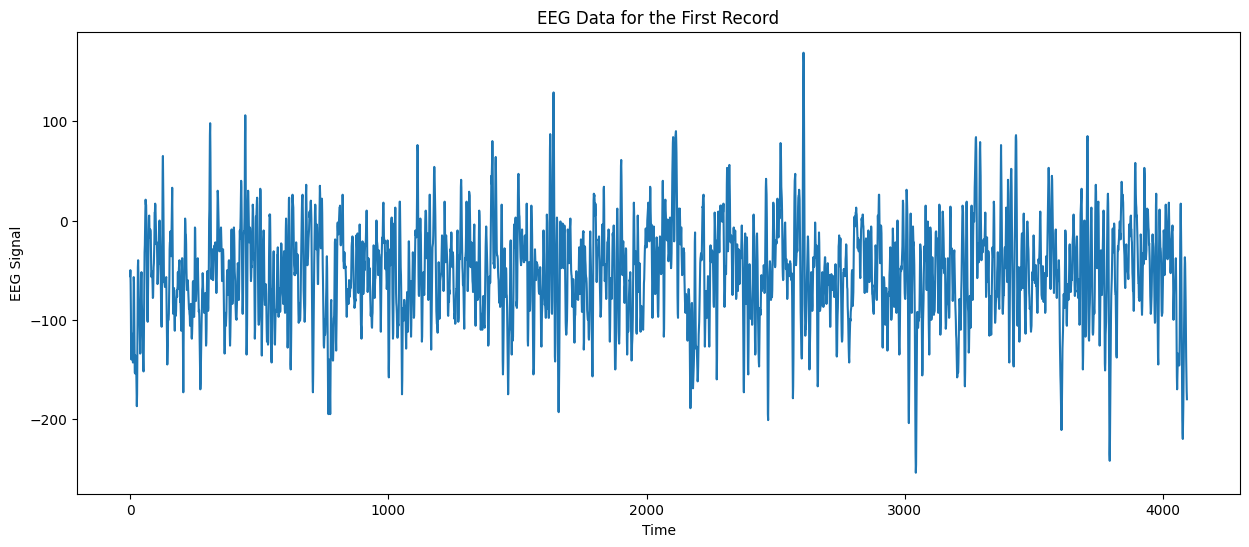

In [ ]:
# Plotting the signal for the first patient
first_row_data = eeg_df.loc[0].drop(['y'])

plt.figure(figsize=(15, 6))
plt.plot(np.arange(4094), first_row_data)
plt.title('EEG Data for the First Record')
plt.xlabel('Time')
plt.ylabel('EEG Signal')
plt.show()

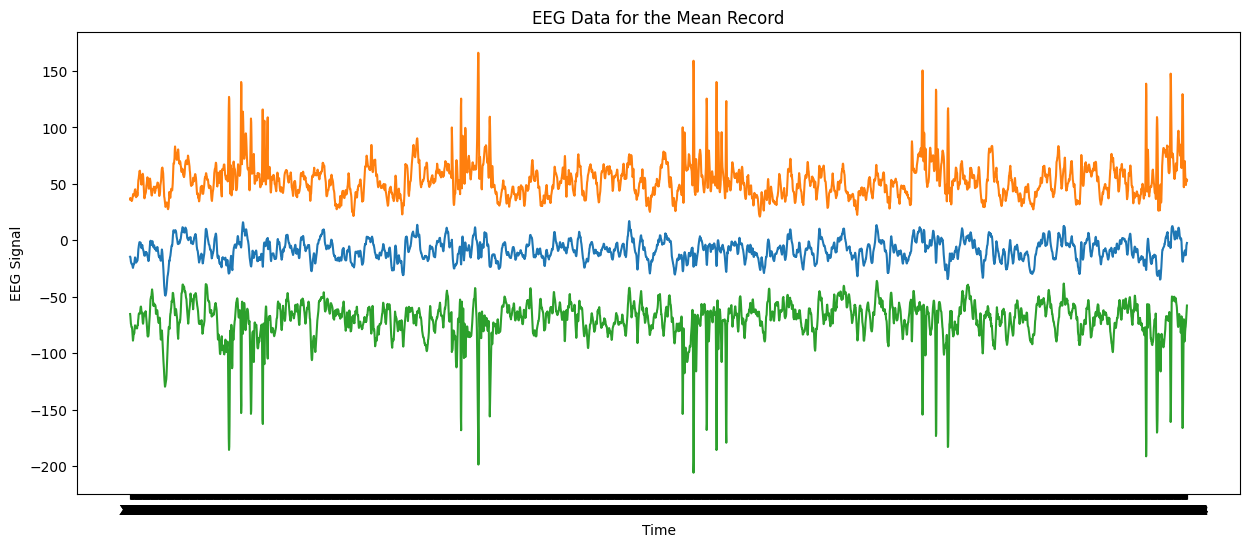

In [ ]:
# Plotting the mean signal for patients of class 3 and the mean +- std
plt.figure(figsize=(15, 6))
plt.plot(patient_3_mean)
plt.plot(patient_3_mean+patient_3_std)
plt.plot(patient_3_mean-patient_3_std)
plt.title('EEG Data for the Mean Record of class 3')
plt.xlabel('Time')
plt.ylabel('EEG Signal')
plt.show()

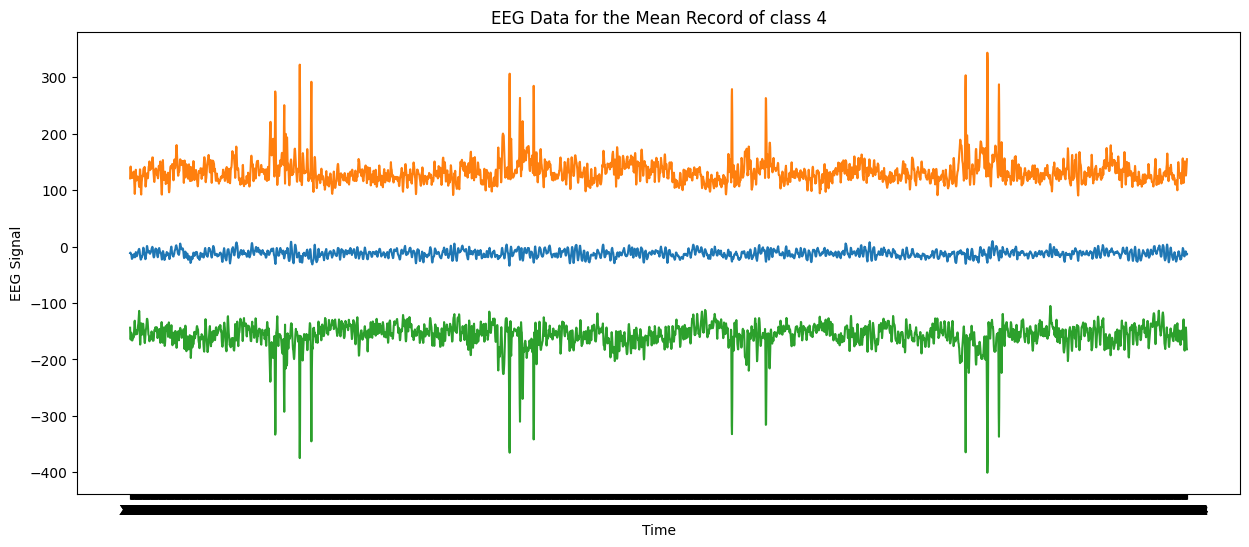

In [ ]:
# Plotting the mean signal for patients of class 4 and the mean +- 2std
plt.figure(figsize=(15, 6))
plt.plot(patient_4_mean)
plt.plot(patient_4_mean+2*patient_4_std)
plt.plot(patient_4_mean-2*patient_4_std)
plt.title('EEG Data for the Mean Record of class 4')
plt.xlabel('Time')
plt.ylabel('EEG Signal')
plt.show()

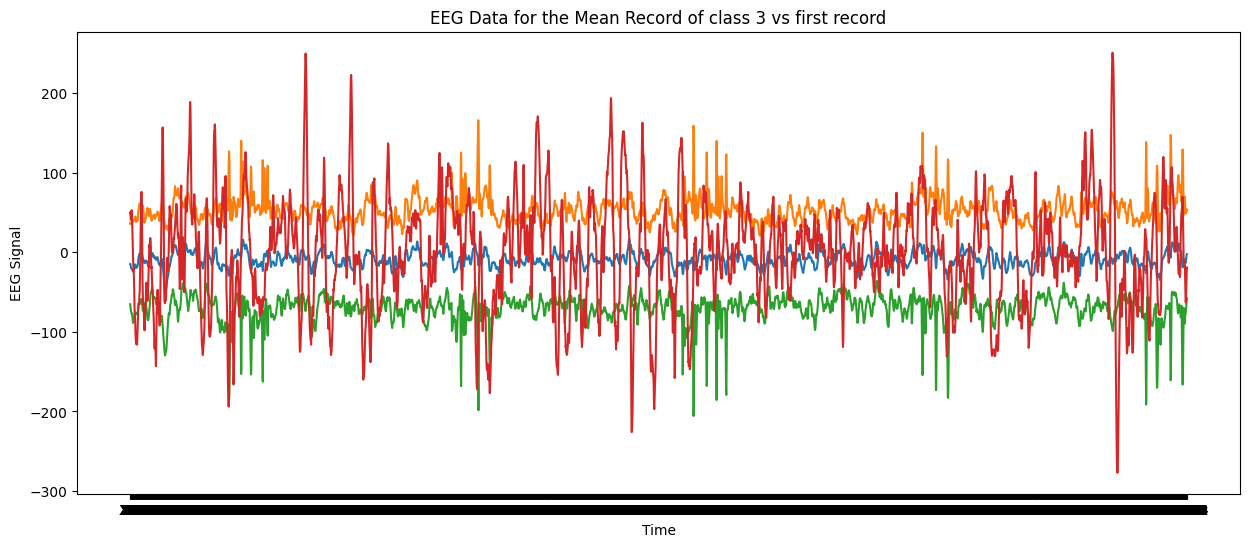

In [ ]:
# First obs of class 3 vs mean and std
plt.figure(figsize=(15, 6))
plt.plot(patient_3_mean)
plt.plot(patient_3_mean+patient_3_std)
plt.plot(patient_3_mean-patient_3_std)
plt.plot(patient_3_data.iloc[1])
plt.title('EEG Data for the Mean Record of class 3 vs First Record')
plt.xlabel('Time')
plt.ylabel('EEG Signal')
plt.show()

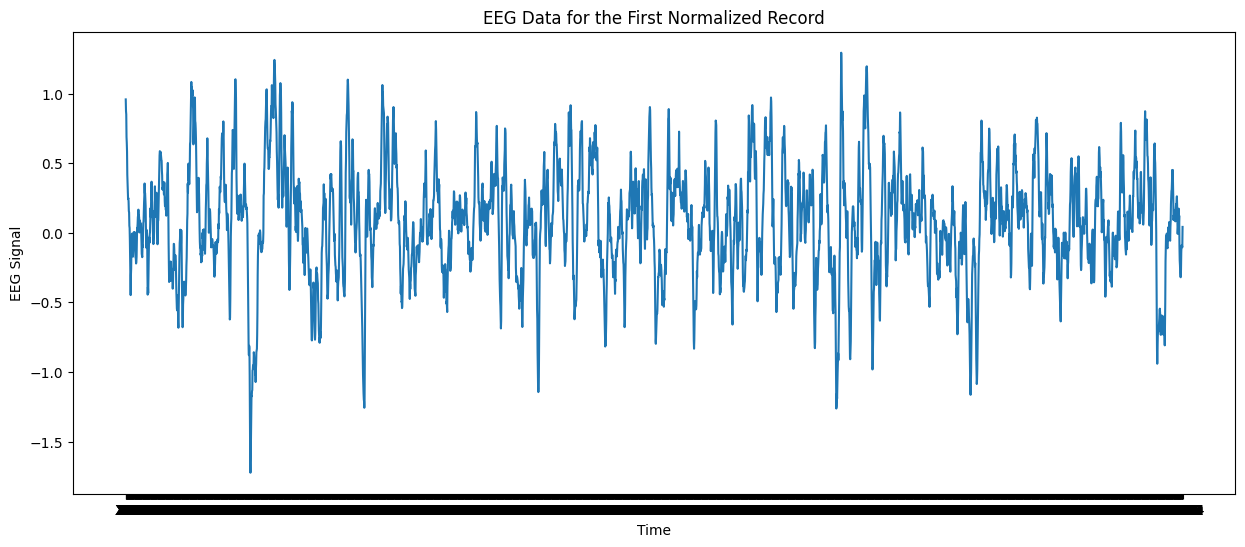

In [ ]:
# Plotting the normalized signal for the first observation
plt.figure(figsize=(15, 6))
plt.plot(normalized_pat3.iloc[0].drop('y'))
plt.title('EEG Data for the First Normalized Record')
plt.xlabel('Time')
plt.ylabel('EEG Signal')
plt.show()

## Feature selection
Performed using one among:
- Correlation
- PCA
- KBest

### - Feature selection with correlation

In [ ]:
correlations = np.abs(np.corrcoef(X.T, y)) #correlation matrix between each feature with themselves and y

correlations[:, -1] # the last column represents the correlation with the response variable

feature_correlations = correlations[:-1, -1] # by removing the last row we remove the autocorrelation of y

sorted_correlations = np.sort(feature_correlations)[::-1] # this sorts the correlations in descending order

sorted_indices = np.argsort(feature_correlations)[::-1] # this sorts the indeces by descending correlation

In [ ]:
print(sorted_indices[0])                                 # the feature corresponding to index 940 ("X941") should have max correlation with y
print(sorted_correlations[0])

print(np.abs(np.corrcoef(X_train["X941"], y_train)))     # we can check

1560
0.14793225352886183
[[1.        0.1006801]
 [0.1006801 1.       ]]


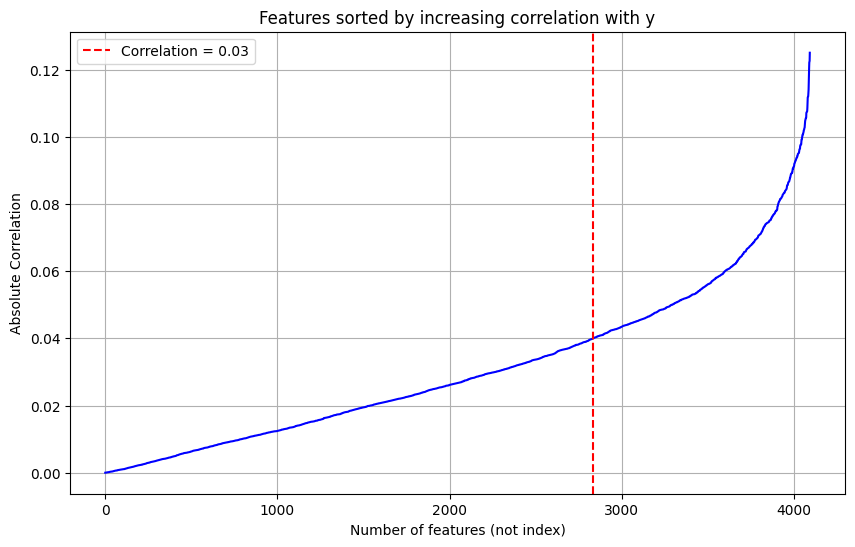

In [ ]:
correlation_threshold = 0.040

x_treshold = len(sorted_correlations)-next((i for i, x in enumerate(sorted_correlations.tolist()) if x < correlation_threshold), None) # index closest to 0.03 correlation

plt.figure(figsize=(10, 6))
plt.plot(feature_correlations[np.argsort(feature_correlations)], linestyle='-', color="b")
plt.axvline(x=x_treshold, color='r', linestyle='--', label='Correlation = 0.03')
plt.xlabel('Number of features (not index)')
plt.ylabel('Absolute Correlation')
plt.title('Features sorted by increasing correlation with y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# select the features that have a correlation with 'y' higher than the set threshold
selected_features = [f"X{sorted_indices[i] + 1}" for i in range(len(sorted_indices)) if sorted_correlations[i] > correlation_threshold]

In [ ]:
selected_features[:5]

['X432', 'X3936', 'X431', 'X3937', 'X3169']

In [ ]:
# Saving an X alternative with feature selection

X = X[selected_features]
X.shape

(155, 1259)

In [ ]:
# Saving X_score alternative

X_score = X_score[selected_features]

### - Feature selection with PCA

In [19]:
# Defining PCA
pca = PCA(n_components=0.8)
X_pca = pca.fit_transform(X)

In [20]:
#print("Variance explained by each component:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", np.cumsum(pca.explained_variance_ratio_))

Cumulative variance explained: [0.17487319 0.21146753 0.24125222 0.26868898 0.2923649  0.31464257
 0.33658379 0.35682871 0.37646425 0.39592992 0.41289565 0.42955278
 0.44499537 0.46022262 0.47494621 0.48899279 0.50238664 0.51529573
 0.52809484 0.54060404 0.55260977 0.56447359 0.57597622 0.58709856
 0.59795723 0.60842109 0.61861628 0.62864181 0.63831553 0.64760717
 0.65670762 0.66547666 0.67397483 0.68214067 0.69023822 0.69810505
 0.70574371 0.71315322 0.72041032 0.72759487 0.73454831 0.74139456
 0.74800162 0.754512   0.76097315 0.76718672 0.77324483 0.77919462
 0.78506821 0.7907704  0.79634231 0.80180406]


In [21]:
# Applying PCA to the testing set
X = pd.DataFrame(X_pca)
X_score = pca.transform(X_score)

### - Feature selection with KBest

In [ ]:
selector = SelectKBest(f_classif, k=500)
selector.fit(X, y)

X = pd.DataFrame(selector.transform(X))
X_score = selector.transform(X_score)

## Defining the metrics

In [22]:
# Definitions of the metrics

def TP(prediction:list, test:list)->int:                          # considering 4 as positive class
     count = 0
     for x in range(len(prediction)):
         if prediction[x]==test[x] and test[x]==4:
             count+=1
     return count

def TN(prediction:list, test:list)->int:                          # considering 3 as negative class
    count = 0
    for x in range(len(prediction)):
        if prediction[x]==test[x] and test[x]==3:
            count+=1
    return count

# FN, FP not needed

def accuracy(prediction:list, test:list)->int:                     # (TP+TN) / n
    return round((TP(prediction, test)+TN(prediction,test))/len(test),3)

def sensitivity(prediction:list, test:list)->int:                  # TP / TP + FN
    return round(TP(prediction, test)/test.count(4),3)

def specificity(prediction:list, test:list)->int:                  # TN / TN + FP
    return round(TN(prediction, test)/test.count(3),3)


def ci(mean, std, n):                             # 95% confidence interval
    z = stats.norm.ppf(0.975)
    margin_of_error = z * (std / (n ** 0.5))
    lower_bound = round((mean - margin_of_error), 3)
    upper_bound = round((mean + margin_of_error), 3)

    return lower_bound, upper_bound




## SVM:

We'll conduct the next analysis both on the full dataset and on the version with no outliers

### Hyperparameters search (with cross-validated grid search)

In [23]:
# Dividing the samples into folds for cross-validation

K = 5

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=100)

train_indices_list = []
test_indices_list = []

for train_index, test_index in skf.split(X, y):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)

# gridsearch:

results = [["kernel","C","degree","accuracy mean cv","accuracy std cv",
            "sensitivity mean cv","sensitivity std cv","specificity mean cv", "specificity std cv",
            "accuracy 95% C.I.", "sensitivity 95% C.I.","specificity 95% C.I."]]

regularization = [1,2,5,10]
kernels = ["linear", "poly", "rbf", "sigmoid"]
degrees = [3,4,5]

for kernel in kernels:
    for c in regularization:
        if kernel == "poly":
            for degree in degrees:
                #print("Parameters: ", kernel,"kernel, ", "C =", str(c), ", degree: ", str(degree))
                scores = {"Accuracy":[],"Sensitivity":[],"Specificity":[]}
                for k in range(K):
                    svm_classifier = SVC(C=c, kernel=kernel, degree=degree).fit(X.iloc[train_indices_list[k]], y.iloc[train_indices_list[k]])

                    predicted = svm_classifier.predict(X.iloc[test_indices_list[k]])
                    #print(classification_report(y.iloc[test_indices_list[k]], predicted))

                    scores["Accuracy"].append(accuracy(predicted.tolist(), y.iloc[test_indices_list[k]].tolist()))
                    scores["Sensitivity"].append(sensitivity(predicted.tolist(), y.iloc[test_indices_list[k]].tolist()))
                    scores["Specificity"].append(specificity(predicted.tolist(), y.iloc[test_indices_list[k]].tolist()))

                # save the results
                results.append([kernel,c, degree, round(np.mean(scores["Accuracy"]),3),round(np.std(scores["Accuracy"]),3),
                            round(np.mean(scores["Sensitivity"]),3),round(np.std(scores["Sensitivity"]),3),
                            round(np.mean(scores["Specificity"]),3),round(np.std(scores["Specificity"]),3),
                            ci(np.mean(scores["Accuracy"]),np.std(scores["Accuracy"]),K),
                            ci(np.mean(scores["Sensitivity"]),np.std(scores["Sensitivity"]),K),
                            ci(np.mean(scores["Specificity"]),np.std(scores["Specificity"]),K)])

        else:
            #print("Parameters: ", kernel,"kernel, ", "C =", str(c))
            scores = {"Accuracy":[],"Sensitivity":[],"Specificity":[]}
            for k in range(K):
                    svm_classifier = SVC(C=c, kernel=kernel).fit(X.iloc[train_indices_list[k]], y.iloc[train_indices_list[k]])

                    predicted = svm_classifier.predict(X.iloc[test_indices_list[k]])
                    #print(classification_report(y.iloc[test_indices_list[k]], predicted))

                    scores["Accuracy"].append(accuracy(predicted.tolist(), y.iloc[test_indices_list[k]].tolist()))
                    scores["Sensitivity"].append(sensitivity(predicted.tolist(), y.iloc[test_indices_list[k]].tolist()))
                    scores["Specificity"].append(specificity(predicted.tolist(), y.iloc[test_indices_list[k]].tolist()))

            # save the results
            results.append([kernel,c, 0, round(np.mean(scores["Accuracy"]),3),round(np.std(scores["Accuracy"]),3),
                            round(np.mean(scores["Sensitivity"]),3),round(np.std(scores["Sensitivity"]),3),
                            round(np.mean(scores["Specificity"]),3),round(np.std(scores["Specificity"]),3),
                            ci(np.mean(scores["Accuracy"]),np.std(scores["Accuracy"]),K),
                            ci(np.mean(scores["Sensitivity"]),np.std(scores["Sensitivity"]),K),
                            ci(np.mean(scores["Specificity"]),np.std(scores["Specificity"]),K)])

# Create a dataframe of the results and sort it by accuracy mean
df = pd.DataFrame(results[1:], columns=results[0])
df = df.sort_values(by='accuracy mean cv', ascending=False).reset_index(drop=True)

# obtain the best hyperparameters
best_SVM_params = df.iloc[0]
df

,kernel,C,degree,accuracy mean cv,accuracy std cv,sensitivity mean cv,sensitivity std cv,specificity mean cv,specificity std cv,accuracy 95% C.I.,sensitivity 95% C.I.,specificity 95% C.I.
0,rbf,5,0,0.813,0.072,0.768,0.194,0.855,0.089,"(0.75, 0.876)","(0.599, 0.938)","(0.777, 0.933)"
1,rbf,10,0,0.806,0.071,0.769,0.169,0.842,0.090,"(0.744, 0.868)","(0.621, 0.917)","(0.764, 0.921)"
2,rbf,2,0,0.806,0.074,0.769,0.169,0.842,0.090,"(0.742, 0.871)","(0.621, 0.917)","(0.764, 0.921)"
3,rbf,1,0,0.716,0.099,0.770,0.123,0.659,0.081,"(0.63, 0.802)","(0.663, 0.878)","(0.588, 0.73)"
4,poly,10,4,0.716,0.099,0.924,0.061,0.501,0.266,"(0.63, 0.802)","(0.87, 0.978)","(0.267, 0.735)"
5,poly,5,3,0.710,0.096,0.911,0.033,0.498,0.203,"(0.626, 0.793)","(0.882, 0.94)","(0.32, 0.677)"
6,poly,10,3,0.710,0.079,0.861,0.073,0.552,0.222,"(0.64, 0.779)","(0.797, 0.925)","(0.357, 0.746)"
7,poly,5,4,0.697,0.111,0.974,0.032,0.408,0.217,"(0.6, 0.794)","(0.946, 1.002)","(0.218, 0.599)"
8,poly,2,3,0.684,0.095,0.936,0.042,0.419,0.185,"(0.601, 0.767)","(0.899, 0.973)","(0.257, 0.581)"
9,poly,10,5,0.658,0.086,0.938,0.097,0.369,0.266,"(0.583, 0.733)","(0.853, 1.022)","(0.136, 0.602)"


### Now, we can follow two different approaches:
- Train a single new model, tuned with the best parameters, on all the available observations, and that's the model we will use for the scoring
- Alternatively, we can perform another 5-folds cross-validation step only with the best tuned model, and we could then use the five obtained model to ensamble our scoring

### Testing the single best model (first approach)

In [24]:
# First approach: best classifier trained on all available data (except score)

svm_classifier = SVC(C=best_SVM_params["C"], kernel=best_SVM_params["kernel"], degree=best_SVM_params["degree"]).fit(X, y)

predicted = svm_classifier.predict(X_score)

print({param: svm_classifier.get_params().get(param) for param in ("C", "kernel", "degree")})

{'C': 5, 'kernel': 'rbf', 'degree': 0}


In [25]:
# Results
print(accuracy(predicted.tolist(), y_score.tolist()))
print(sensitivity(predicted.tolist(), y_score.tolist()))
print(specificity(predicted.tolist(), y_score.tolist()))

0.875
0.75
1.0


<Figure size 10000x10000 with 0 Axes>

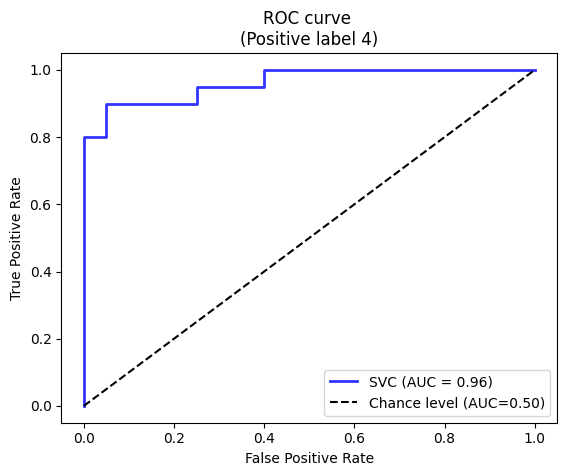

In [26]:
# ROC Curve with AUC
plt.figure(figsize=(10, 10), dpi=1000)
svc_disp = RocCurveDisplay.from_estimator(svm_classifier, X_score, y_score, alpha=0.8, lw=2, color="b")  # ROC
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Chance level (AUC=0.50)") # alternative chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve \n(Positive label {4})')

plt.legend(loc="lower right")
plt.show()

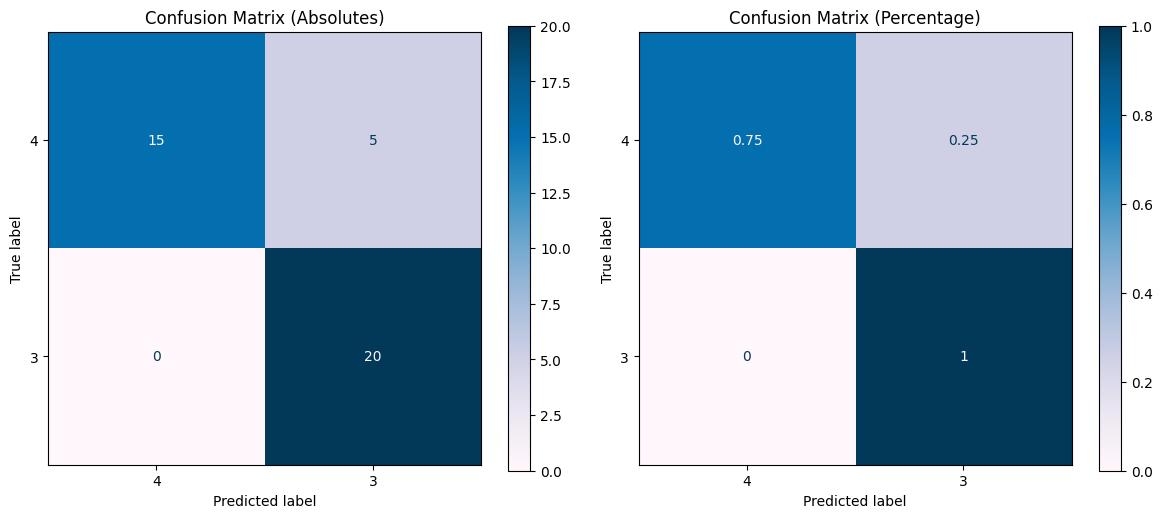

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

color_map = "PuBu"

# Plot confusion matrix with absolute values
axs[0].set_title('Confusion Matrix (Absolutes)')
CM_absolute = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_score.tolist(), predicted, labels=[4,3]),
    display_labels=[4,3])
CM_absolute.plot(cmap=color_map, ax=axs[0])

# Plot confusion matrix with percentages
axs[1].set_title('Confusion Matrix (Percentage)')
conf_matrix = confusion_matrix(y_score, predicted, labels=[4,3])
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
CM_percentage = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=[4,3])
CM_percentage.plot(cmap=color_map, ax=axs[1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Testing the Ensemble of the 5 best models (second approach)

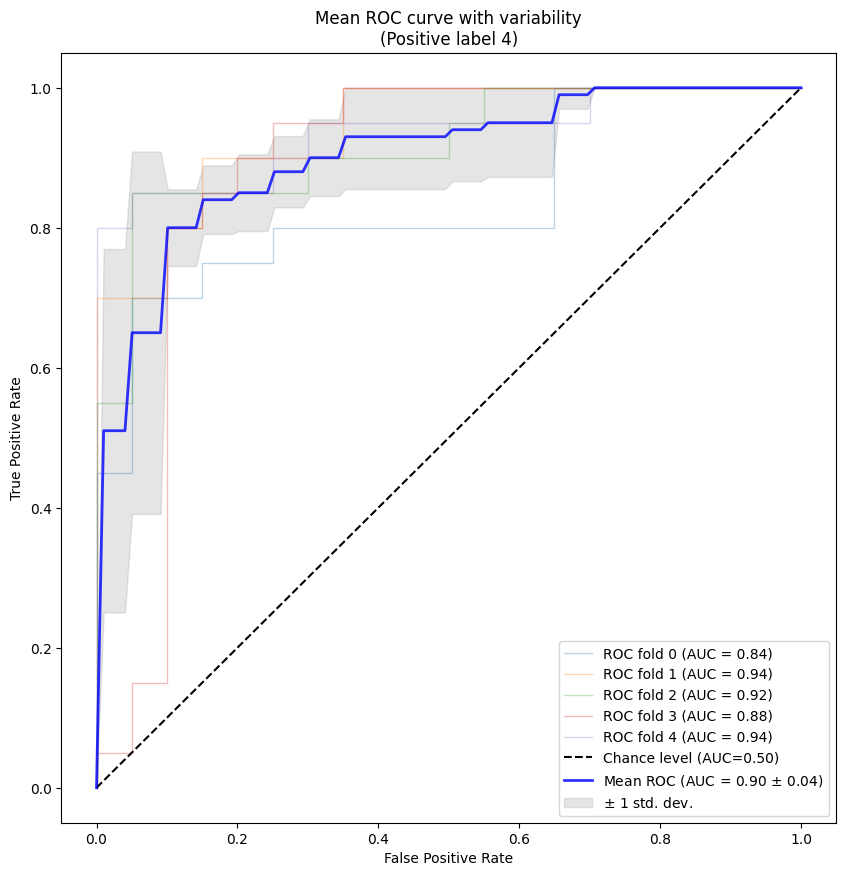

In [28]:
# Second approach: cross-validation and using all the models to perform ensamble classification on the score set

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

SVM_classifiers = []

tprs = []   # true positive rates
aucs = []   # areas under the curves
mean_fpr = np.linspace(0, 1, 100)

train_indices_list = []
test_indices_list = []

for train_index, test_index in skf.split(X, y):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)

fig, ax = plt.subplots(figsize=(10, 10))

for k in range(K):
    classifier = SVC(C=best_SVM_params["C"], kernel=best_SVM_params["kernel"], degree=best_SVM_params["degree"])
    svm_classifier =classifier.fit(X.iloc[train_indices_list[k]],     # 5 ROCs
                                   y.iloc[train_indices_list[k]])
    SVM_classifiers.append(svm_classifier)
    viz = RocCurveDisplay.from_estimator(svm_classifier,
          X_score,y_score, name=f"ROC fold {k}",
          alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], color='black', linestyle='--',                # Chance level
        label="Chance level (AUC=0.50)")

mean_tpr = np.mean(tprs, axis=0)                                      # mean ROC
#mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)"
        % (mean_auc, std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)                                         # std
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper,
                color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",      # labels
       title=f"Mean ROC curve with variability\n(Positive label {4})")

ax.legend(loc="lower right")
plt.show()

In [29]:
# Make predictions on scoring set with all the models
predictions = [
    [SVM_classifiers[classifier].predict(X_score)[obs] for classifier in range(len(SVM_classifiers))]
    for obs in range(len(X_score))]

In [31]:
# Obtain a final array of predictions by taking the mode (most-voted class)
ensembled_prediction = [mode(predictions[obs])[0] for obs in range(len(predictions))]

In [32]:
# Results
print(accuracy(ensembled_prediction, y_score.tolist()))
print(sensitivity(ensembled_prediction, y_score.tolist()))
print(specificity(ensembled_prediction, y_score.tolist()))

0.9
0.85
0.95


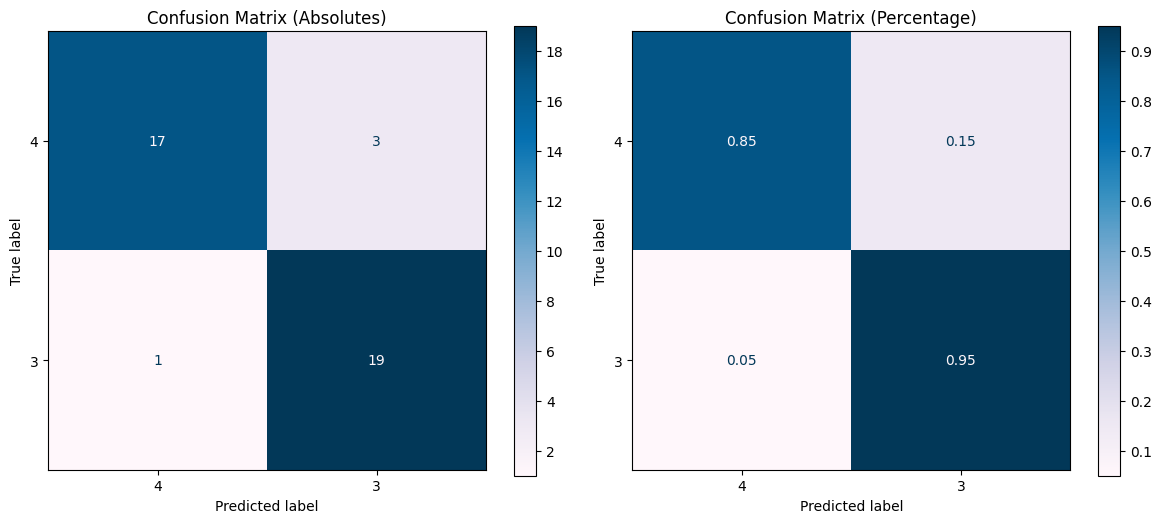

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

color_map = "PuBu"

# Plot confusion matrix with absolute values
axs[0].set_title('Confusion Matrix (Absolutes)')
CM_absolute = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_score.tolist(), ensembled_prediction, labels=[4,3]),
    display_labels=[4,3])
CM_absolute.plot(cmap=color_map, ax=axs[0])

# Plot confusion matrix with percentages
axs[1].set_title('Confusion Matrix (Percentage)')
conf_matrix = confusion_matrix(y_score, ensembled_prediction, labels=[4,3])
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
CM_percentage = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=[4,3])
CM_percentage.plot(cmap=color_map, ax=axs[1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Random Forest:

### Hyperparameters search (with cross-validated grid search)

In [34]:
# Dividing the samples into folds for cross-validation


K = 5

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=100)

train_indices_list = []
test_indices_list = []

for train_index, test_index in skf.split(X, y):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)

# gridsearch:

results = [["num estimators", "criterion","maximum depth", "max num of features","accuracy mean cv","accuracy std cv",
            "sensitivity mean cv","sensitivity std cv","specificity mean cv", "specificity std cv",
            "accuracy 95% C.I.", "sensitivity 95% C.I.","specificity 95% C.I."]]

num_estimators = [50,100, 200, 500]
criterion = ["gini", "entropy", "log_loss"]
max_depth = [None, 3, 5, 7, 10]
max_feat = ["sqrt", "log2"]

for n_estim in num_estimators:
    for crit in criterion:
        for depth in max_depth:
          for feat in max_feat:
                #print("Parameters: ", kernel,"kernel, ", "C =", str(c), ", degree: ", str(degree))
                scores = {"Accuracy":[],"Sensitivity":[],"Specificity":[]}
                for k in range(K):
                    rf_classifier = RandomForestClassifier(n_estimators=n_estim, criterion=crit, max_depth=depth, max_features=feat)
                    rf_classifier.fit(X.iloc[train_indices_list[k]], y.iloc[train_indices_list[k]])

                    predicted = rf_classifier.predict(X.iloc[test_indices_list[k]])
                    #print(classification_report(y.iloc[test_indices_list[k]], predicted))

                    scores["Accuracy"].append(accuracy(predicted.tolist(), y.iloc[test_indices_list[k]].tolist()))
                    scores["Sensitivity"].append(sensitivity(predicted.tolist(), y.iloc[test_indices_list[k]].tolist()))
                    scores["Specificity"].append(specificity(predicted.tolist(), y.iloc[test_indices_list[k]].tolist()))

                # save the results
                results.append([n_estim,crit,depth,feat, round(np.mean(scores["Accuracy"]),3),round(np.std(scores["Accuracy"]),3),
                            round(np.mean(scores["Sensitivity"]),3),round(np.std(scores["Sensitivity"]),3),
                            round(np.mean(scores["Specificity"]),3),round(np.std(scores["Specificity"]),3),
                            ci(np.mean(scores["Accuracy"]),np.std(scores["Accuracy"]),K),
                            ci(np.mean(scores["Sensitivity"]),np.std(scores["Sensitivity"]),K),
                            ci(np.mean(scores["Specificity"]),np.std(scores["Specificity"]),K)])


# Create a dataframe of the results and sort it by accuracy mean
df = pd.DataFrame(results[1:], columns=results[0])
df.replace({np.nan: None}, inplace=True)

# Obtain the best hyperparameters
df = df.sort_values(by='accuracy mean cv', ascending=False).reset_index(drop=True)
best_rf_params = df.iloc[0]
df

,num estimators,criterion,maximum depth,max num of features,accuracy mean cv,accuracy std cv,sensitivity mean cv,sensitivity std cv,specificity mean cv,specificity std cv,accuracy 95% C.I.,sensitivity 95% C.I.,specificity 95% C.I.
0,500,gini,10.0,log2,0.877,0.083,0.898,0.051,0.858,0.13,"(0.805, 0.95)","(0.854, 0.943)","(0.743, 0.972)"
1,50,log_loss,10.0,log2,0.871,0.029,0.899,0.05,0.842,0.09,"(0.846, 0.896)","(0.856, 0.943)","(0.764, 0.921)"
2,200,gini,None,log2,0.871,0.074,0.873,0.09,0.87,0.116,"(0.807, 0.935)","(0.793, 0.952)","(0.769, 0.971)"
3,100,gini,7.0,sqrt,0.871,0.074,0.873,0.059,0.871,0.12,"(0.807, 0.935)","(0.821, 0.924)","(0.766, 0.976)"
4,100,entropy,10.0,log2,0.865,0.09,0.885,0.064,0.845,0.129,"(0.786, 0.943)","(0.829, 0.941)","(0.732, 0.958)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,50,entropy,3.0,sqrt,0.781,0.127,0.809,0.072,0.752,0.189,"(0.67, 0.892)","(0.746, 0.872)","(0.586, 0.918)"
116,100,entropy,3.0,sqrt,0.781,0.131,0.795,0.129,0.766,0.159,"(0.666, 0.896)","(0.682, 0.908)","(0.626, 0.905)"
117,500,entropy,3.0,sqrt,0.774,0.102,0.821,0.066,0.725,0.167,"(0.685, 0.863)","(0.764, 0.879)","(0.578, 0.872)"
118,50,log_loss,5.0,sqrt,0.774,0.11,0.772,0.065,0.778,0.201,"(0.678, 0.871)","(0.714, 0.829)","(0.603, 0.954)"


### Testing the best model (first approach)

In [35]:
# First approach: best classifier trained on all available data (except score)

if best_rf_params["maximum depth"]!=None:
  best_rf_params["maximum depth"] = int(best_rf_params["maximum depth"])

rf_classifier = RandomForestClassifier(n_estimators=best_rf_params["num estimators"],
                                       criterion=best_rf_params["criterion"],
                                       max_depth=best_rf_params["maximum depth"],
                                       max_features=best_rf_params["max num of features"])
rf_classifier.fit(X, y)

predicted = rf_classifier.predict(X_score)

/var/folders/v6/wd3ltjyx7h71vcq9vqb_4vd80000gn/T/ipykernel_7055/3296654657.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_rf_params["maximum depth"] = int(best_rf_params["maximum depth"])


In [36]:
# Results
print(accuracy(predicted.tolist(), y_score.tolist()))
print(sensitivity(predicted.tolist(), y_score.tolist()))
print(specificity(predicted.tolist(), y_score.tolist()))

0.975
1.0
0.95


In [37]:
# Extracting the top "nBest" important features
nBest = 5
feat_imp = rf_classifier.feature_importances_
indices = sorted(range(len(feat_imp)), key=lambda i: feat_imp[i], reverse=True)[:nBest]
for i in range(nBest):
  print(f"{i+1}) X{indices[i]+1}")

1) X4
2) X5
3) X14
4) X10
5) X1


<Figure size 10000x10000 with 0 Axes>

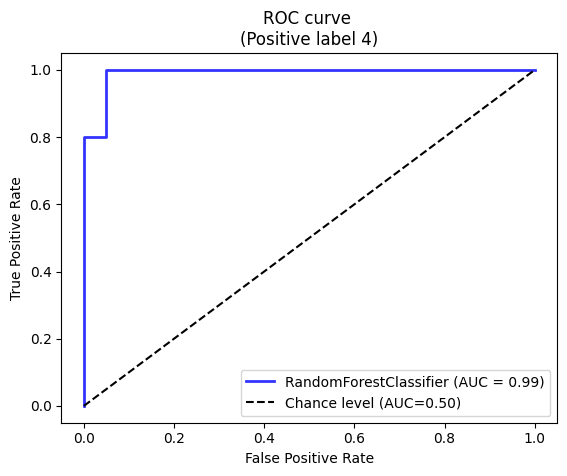

In [38]:
# ROC Curve with AUC
plt.figure(figsize=(10, 10), dpi=1000)
svc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_score, y_score, alpha=0.8, lw=2, color="b")  # ROC
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Chance level (AUC=0.50)") # alternative chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve \n(Positive label {4})')

plt.legend(loc="lower right")
plt.show()

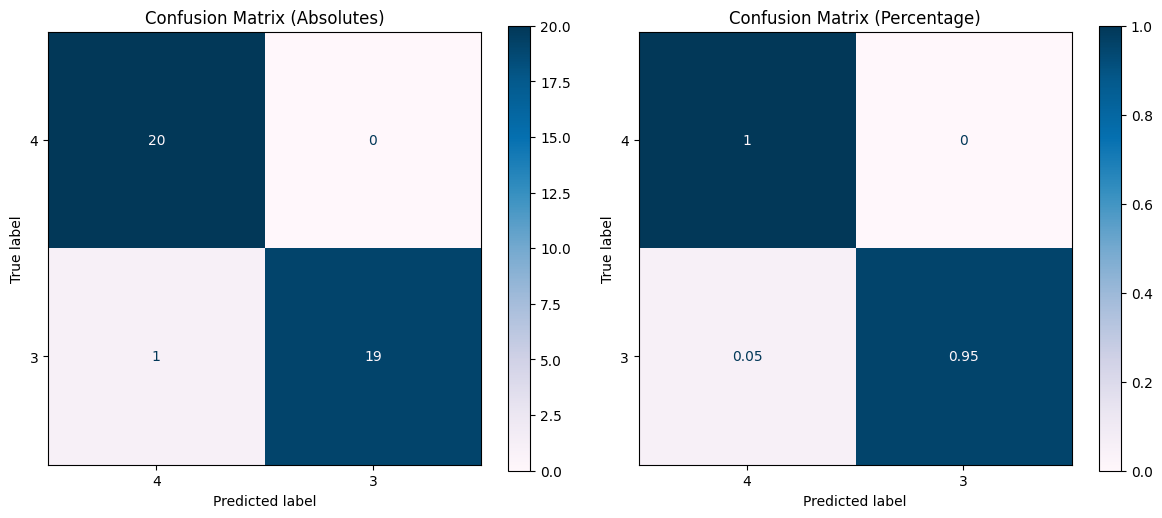

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

color_map = "PuBu"

# Plot confusion matrix with absolute values
axs[0].set_title('Confusion Matrix (Absolutes)')
CM_absolute = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_score.tolist(), predicted, labels=[4,3]),
    display_labels=[4,3])
CM_absolute.plot(cmap=color_map, ax=axs[0])

# Plot confusion matrix with percentages
axs[1].set_title('Confusion Matrix (Percentage)')
conf_matrix = confusion_matrix(y_score, predicted, labels=[4,3])
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
CM_percentage = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=[4,3])
CM_percentage.plot(cmap=color_map, ax=axs[1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Testing Ensemble of 5 best models (second approach)

/var/folders/v6/wd3ltjyx7h71vcq9vqb_4vd80000gn/T/ipykernel_7055/1977613057.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_rf_params["maximum depth"] = int(best_rf_params["maximum depth"])


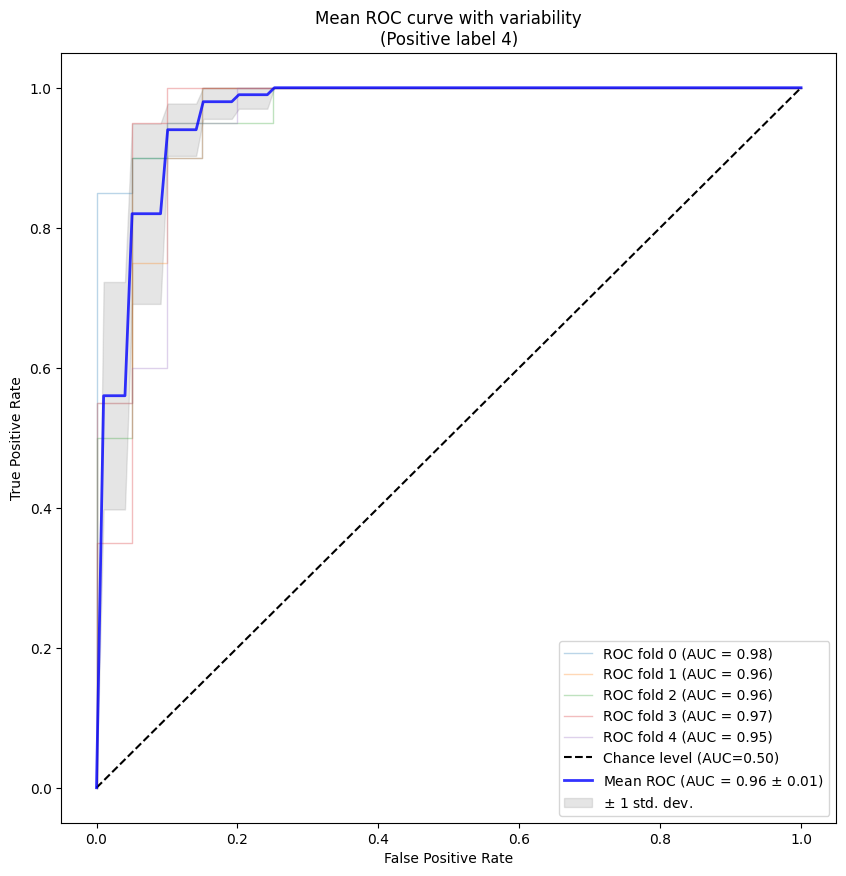

In [40]:
# Second approach: cross-validation and using all the models to perform ensamble classification on the score set

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

rf_classifiers = []

tprs = []   # true positive rates
aucs = []   # areas under the curves
mean_fpr = np.linspace(0, 1, 100)

train_indices_list = []
test_indices_list = []

for train_index, test_index in skf.split(X, y):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)

fig, ax = plt.subplots(figsize=(10, 10))


if best_rf_params["maximum depth"]!=None:
  best_rf_params["maximum depth"] = int(best_rf_params["maximum depth"])

for k in range(K):
    classifier = RandomForestClassifier(n_estimators=best_rf_params["num estimators"],
                                       criterion=best_rf_params["criterion"],
                                       max_depth=best_rf_params["maximum depth"],
                                       max_features=best_rf_params["max num of features"])
    rf_classifier =classifier.fit(X.iloc[train_indices_list[k]],     # 5 ROCs
                                   y.iloc[train_indices_list[k]])
    rf_classifiers.append(rf_classifier)
    viz = RocCurveDisplay.from_estimator(rf_classifier,
          X_score,y_score, name=f"ROC fold {k}",
          alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], color='black', linestyle='--',                # Chance level
        label="Chance level (AUC=0.50)")

mean_tpr = np.mean(tprs, axis=0)                                      # mean ROC
#mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)"
        % (mean_auc, std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)                                         # std
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper,
                color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",      # labels
       title=f"Mean ROC curve with variability\n(Positive label {4})")

ax.legend(loc="lower right")
plt.show()

In [41]:
# Make predictions on scoring set with all the models
predictions = [
    [rf_classifiers[classifier].predict(X_score)[obs] for classifier in range(len(rf_classifiers))]
    for obs in range(len(X_score))]

In [43]:
# Obtain a final array of predictions by taking the mode (most-voted class)
ensembled_prediction = [mode(predictions[obs])[0] for obs in range(len(predictions))]

In [44]:
# Results
print(accuracy(ensembled_prediction, y_score.tolist()))
print(sensitivity(ensembled_prediction, y_score.tolist()))
print(specificity(ensembled_prediction, y_score.tolist()))

0.95
0.95
0.95


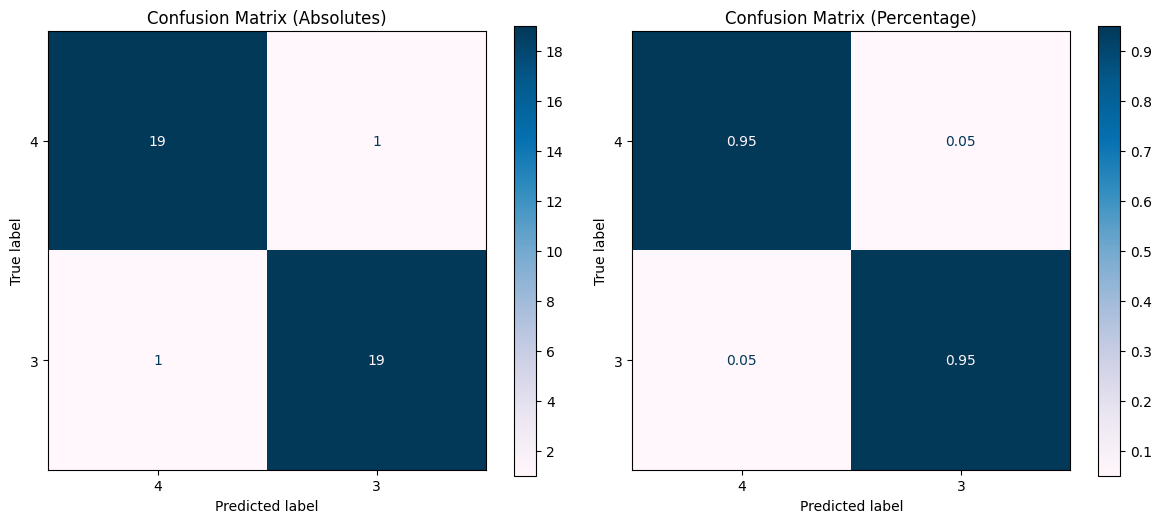

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

color_map = "PuBu"

# Plot confusion matrix with absolute values
axs[0].set_title('Confusion Matrix (Absolutes)')
CM_absolute = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_score.tolist(), ensembled_prediction, labels=[4,3]),
    display_labels=[4,3])
CM_absolute.plot(cmap=color_map, ax=axs[0])

# Plot confusion matrix with percentages
axs[1].set_title('Confusion Matrix (Percentage)')
conf_matrix = confusion_matrix(y_score, ensembled_prediction, labels=[4,3])
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
CM_percentage = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=[4,3])
CM_percentage.plot(cmap=color_map, ax=axs[1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()